<font size="+3"><strong>2.3. Predicting Price with Neighborhood</strong></font>

In [6]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

In [7]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract neighborhood
    df['neighborhood'] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace = True)

    return df

**Task 2.3.1:** Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory. Assign this list to the variable name `files`.

In [8]:
files = glob('../data/raw/buenos-aires-real-estate-*.csv')
files

['../data/raw\\buenos-aires-real-estate-1.csv',
 '../data/raw\\buenos-aires-real-estate-2.csv',
 '../data/raw\\buenos-aires-real-estate-3.csv',
 '../data/raw\\buenos-aires-real-estate-4.csv',
 '../data/raw\\buenos-aires-real-estate-5.csv']

**Task 2.3.2:** Use your `wrangle` function in a `for` loop to create a list named `frames`. The list should the cleaned DataFrames created from the CSV filenames your collected in `files`.

In [9]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

**Task 2.3.3:** Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate the items in `frames` into a single DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

In [13]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


**Task 2.3.4:** Modify your `wrangle` function to create a new feature `"neighborhood"`. You can find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, your function should drop the `"place_with_parent_names"` column.

**Task 2.3.5:** Create your feature matrix `X_train` and target vector `y_train`. `X_train` should contain one feature: `"neighborhood"`. Your target is `"price_aprox_usd"`. 

In [14]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

**Task 2.3.6:** Calculate the baseline mean absolute error for your model.

In [15]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


**Task 2.3.7:** First, instantiate a `OneHotEncoder` named `ohe`. Make sure to set the `use_cat_names` argument to `True`. Next, fit your transformer to the feature matrix `X_train`. Finally, use your encoder to transform the feature matrix `X_train`, and assign the transformed data to the variable `XT_train`.

In [16]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Fit
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Task 2.3.8:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor. Then fit your model to the training data. 


In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

**Task 2.3.9:** First, create a list of predictions for the observations in your feature matrix `X_train`. Name this list `y_pred_training`. Then calculate the training mean absolute error for your predictions in `y_pred_training` as compared to the true targets in `y_train`.

In [18]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


**Task 2.3.10:** Run the code below to import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a Series of predictions using your model. Then run the following cell to submit your predictions to the grader.


In [20]:
X_test = pd.read_csv("../data/raw/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

**Task 2.3.11:** Extract the intercept and coefficients for your model. 

In [21]:
intercept = model.named_steps['ridge'].intercept_
coefficients = model.named_steps['ridge'].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


**Task 2.3.12:** Extract the feature names of your encoded data from the `OneHotEncoder` in your model.

In [22]:
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita' 'neighborhood_Villa Luro'
 'neighborhood_Caballito' 'neighborhood_Constitución' 'neighborhood_Once']


c:\Users\Coop\Desktop\WQU\Housing-in-Buenos-Aires\.venv\Lib\site-packages\category_encoders\utils.py:379: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


**Task 2.3.13:** Create a pandas Series named `feat_imp` where the index is your `features` and the values are your `coefficients`.

In [23]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

**Task 2.3.14:** Run the cell below to print the equation that your model has determined for predicting apartment price based on longitude and latitude.

In [24]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constitución)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nuñez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

**Task 2.3.15:** Scroll up, change the predictor in your model to `Ridge`, and retrain it. Then evaluate the model's training and test performance. Do you still have an overfitting problem? If not, extract the intercept and coefficients again (you'll need to change your code a little bit) and regenerate the model's equation. Does it look different than before?

In [25]:
# Check your work
assert isinstance(
    model[-1], Ridge
), "Did you retrain your model using a `Ridge` predictor?"

**Task 2.3.16:** Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

Text(0.5, 1.0, 'Feature Importance for Apartement Price')

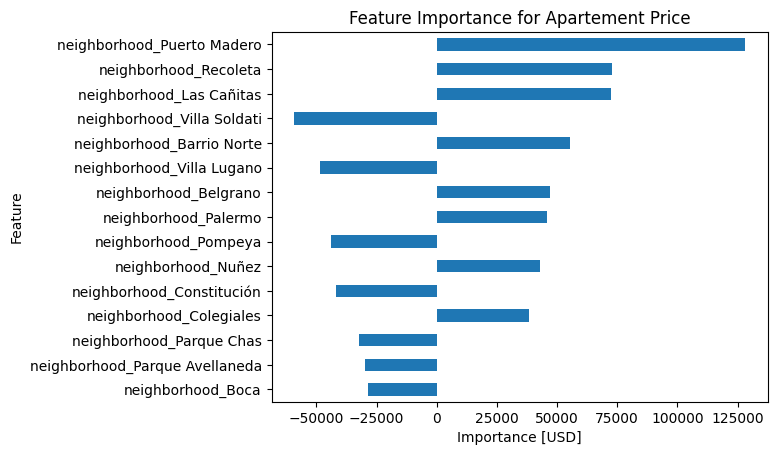

In [26]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartement Price")